In [10]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [11]:
class MyDataset(Dataset):
    # 构造函数
    def __init__(self, data_tensor, target_tensor):
        self.data_tensor = data_tensor
        self.target_tensor = target_tensor
    # 返回数据集大小
    def __len__(self):
        return self.data_tensor.size(0)
    # 返回索引的数据与标签
    def __getitem__(self, index):
        return self.data_tensor[index], self.target_tensor[index]

In [12]:
from scipy.io import loadmat
file6 = "D:\\320 Deep-learning\data\\1118_S6_time1000.mat"
data6 = loadmat(file6)
file12 = "D:\\320 Deep-learning\data\\1111_S12_time1000.mat"
data12 = loadmat(file12)
file24 = "D:\\320 Deep-learning\data\\1111_S24_time1000.mat"
data24 = loadmat(file24)
""" experiment
X_train = data['Input']
X_train = torch.from_numpy(X_train).float()
y_train = data['Stability']
y_train = y_train.astype(np.float32) / 255
y_train = torch.tensor(y_train)
len_train = len(y_train)
X_test = data['PreInput']
X_test = torch.from_numpy(X_test).float()
y_test = data['PreSta']
y_test = y_test.astype(np.float32) / 255
y_test = torch.tensor(y_test)
len_test = len(y_test) """

#simulation
X6 = data6['Input_Presence']
X6 = torch.from_numpy(X6).float()
y6 = data6['Stability']
y6 = torch.from_numpy(y6).float()

X12 = data12['Input_RelativeAbundance']
X12 = torch.from_numpy(X12).float()
y12 = data12['Stability']
y12 = torch.from_numpy(y12).float()

X24 = data24['Input_Presence']
X24 = torch.from_numpy(X24).float()
y24= data24['Stability']
y24 = torch.from_numpy(y24).float()

t = 700
X_train = X24[0:t,:]
y_train = X24[0:t,2]
X_test = X24[t:1000,:]
y_test = X24[t:1000,2]

len_train = len(y_train)
len_test = len(y_test)

# total number of 0 or 1 in training data (prepare for weight)
Num_0 = (y_train==0).sum()
Num_1 = (y_train==1).sum()
Weights = torch.Tensor([Num_0.item()/Num_0.item(),Num_0.item()/Num_1.item()])


# 将数据封装成Dataset
train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)

In [13]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_dataloader = DataLoader(dataset = train_dataset, # 传入的数据集, 必须参数
                               batch_size = batch_size,       # 输出的batch大小
                               shuffle = True,       # 数据是否打乱
                               num_workers = num_workers)      # 进程数, 0表示只有主进程
test_dataloader = DataLoader(dataset = test_dataset, # 传入的数据集, 必须参数
                               batch_size = batch_size,       # 输出的batch大小
                               shuffle = True,       # 数据是否打乱
                               num_workers = num_workers)      # 进程数, 0表示只有主进程


In [14]:
import torch.nn as nn
import torch.nn.functional as F

# define NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(54, 2)
    def forward(self,x):
        #x = self.fc1(x) 
        x = F.sigmoid(self.fc1(x))
        return x

# initialize the NN
model = Net()
#print(model)

In [15]:
# specify loss function
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
# specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

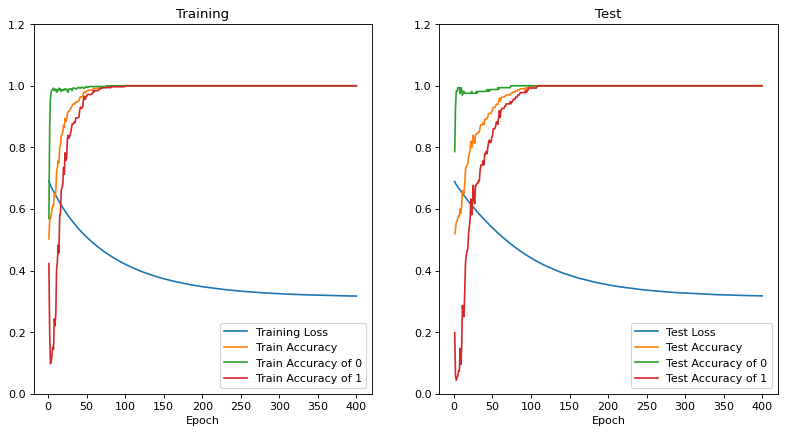

In [16]:
# number of epochs to train the model
n_epochs = 400
train_loss_min = np.Inf  # set initial "min" to infinity
train_loss_curve = list()
train_acc = list()
train_acc1 = list()
train_acc0 = list()
test_loss_curve = list()
test_acc = list()
test_acc1 = list()
test_acc0 = list()

for epoch in range(n_epochs):
    train_loss = 0
    class_correct = list(0. for i in range(2))
    class_total = list(0. for i in range(2))
    # train the model #
    loss = 0
    for data, target in train_dataloader: 
        optimizer.zero_grad()
        output = model(data)
        #make target a tensor:torch.Size([10]),dtype = long
        target = target.view(batch_size)
        target = target.long()
        #target = target.T
        loss = criterion(output,target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        pred = output.argmax(dim=1)
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        for i in range(len(target)):
            if (target.data[i]>0.5):
                label = 1
            else:
                label = 0
        #label = torch.tensor(target.data[i], dtype=torch.int64)
            class_correct[label] += correct[i].item()
            class_total[label] += 1
    train_acc.append(np.sum(class_correct) / np.sum(class_total))
    train_acc0.append(class_correct[0] / class_total[0])
    train_acc1.append(class_correct[1] / class_total[1])


    # calculate average loss over an epoch
    train_loss = train_loss / len_train
    train_loss_curve.append(train_loss)
    #print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, train_loss))
    
    # save model
    if train_loss <= train_loss_min:
        #print('Train loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(train_loss_min,train_loss))
        torch.save(model.state_dict(), 'model.pt')
        train_loss_min = train_loss

    test_loss = 0.0
    class_correct = list(0. for i in range(2))
    class_total = list(0. for i in range(2))

    for data, target in test_dataloader:
        output = model(data)
        target = target.view(batch_size)
        target = target.long()
        loss = criterion(output, target)
        test_loss += loss.item()*data.size(0)
        pred = output.argmax(dim=1)
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        for i in range(len(target)):
            if (target.data[i]>0.5):
                label = 1
            else:
                label = 0
        #label = torch.tensor(target.data[i], dtype=torch.int64)
            class_correct[label] += correct[i].item()
            class_total[label] += 1
    test_acc.append(np.sum(class_correct) / np.sum(class_total))
    test_acc0.append(class_correct[0] / class_total[0])
    test_acc1.append(class_correct[1] / class_total[1])
    test_loss = test_loss/len_test
    test_loss_curve.append(test_loss)


figure, axes = plt.subplots( nrows=1, ncols=2, figsize=(12,6), dpi=80 )
axes[0].plot(np.linspace(1,n_epochs,n_epochs),train_loss_curve,label = 'Training Loss')
axes[1].plot(np.linspace(1,n_epochs,n_epochs),test_loss_curve,label = 'Test Loss')
axes[1].plot(np.linspace(1,n_epochs,n_epochs),test_acc, label = 'Test Accuracy')
axes[1].plot(np.linspace(1,n_epochs,n_epochs),test_acc0, label = 'Test Accuracy of 0')
axes[1].plot(np.linspace(1,n_epochs,n_epochs),test_acc1, label = 'Test Accuracy of 1')
axes[0].plot(np.linspace(1,n_epochs,n_epochs),train_acc, label = 'Train Accuracy')
axes[0].plot(np.linspace(1,n_epochs,n_epochs),train_acc0, label = 'Train Accuracy of 0')
axes[0].plot(np.linspace(1,n_epochs,n_epochs),train_acc1, label = 'Train Accuracy of 1')
axes[0].set_title('Training')
axes[0].set_xlabel('Epoch')
axes[0].set_ylim(0,1.2)
axes[0].legend()
axes[1].set_title('Test')
axes[1].set_xlabel('Epoch')
axes[1].set_ylim(0,1.2)
axes[1].legend()
plt.show()

In [17]:
model.load_state_dict(torch.load('model.pt'))
print(model.fc1.weight)

test_loss = 0.0
correct = 0
OUTPUT = []

for i in range(len_test):
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(X_test[i])
    o = output.tolist()
    OUTPUT.append(o)



Parameter containing:
tensor([[ 0.1146,  0.2942, -9.5155,  0.2545,  0.1440,  0.2806,  0.1048,  0.2203,
          0.3071,  0.1485,  0.2428,  0.2944,  0.0691,  0.2667,  0.1056,  0.3556,
          0.3146,  0.1734,  0.2125,  0.0695,  0.1514,  0.2116,  0.1515,  0.4392,
          0.0758,  0.0951,  0.4666,  0.1928,  0.3318,  0.3492,  0.3022,  0.2135,
          0.2787,  0.2430,  0.1428,  0.1461,  0.0698,  0.2657,  0.2489,  0.1661,
          0.3685,  0.3130,  0.3746,  0.2319,  0.3901,  0.2789,  0.1487,  0.0712,
          0.1738,  0.2297,  0.2280,  0.1978,  0.2365,  0.3556],
        [-0.1126, -0.2921,  9.5111, -0.2525, -0.1420, -0.2786, -0.1027, -0.2182,
         -0.3051, -0.1464, -0.2407, -0.2923, -0.0669, -0.2646, -0.1036, -0.3536,
         -0.3125, -0.1713, -0.2104, -0.0674, -0.1493, -0.2096, -0.1494, -0.4371,
         -0.0737, -0.0930, -0.4646, -0.1908, -0.3298, -0.3472, -0.3001, -0.2114,
         -0.2767, -0.2410, -0.1407, -0.1440, -0.0677, -0.2637, -0.2468, -0.1640,
         -0.3665, -0.31

In [18]:
for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Accuracy of     0: 100% (164/164)
Test Accuracy of     1: 100% (136/136)

Test Accuracy (Overall): 100% (300/300)
